## Classificação de redes complexas

#### Ricardo Tetti Camacho - 10728098 - ricardotetti.camacho@usp.br

Usando o knn é possível ver qual modelo de rede se encaixa melhor na real analisada e utilizando decision tree consiguimos ver qual medida mais influenciou na decisão da rede, como parâmetro sendo um valor entre 0 e 1, com zero sendo um parametro que não influenciou na analise e 1 sendo o parâmetro que influenciou majoritariamente. Com o uso do PCA reduzimos a dimensão dos nossos dados para visualiza-los em um gráfico.

Com os resultados, que podem ser visualizados abaixo, conseguimos ver que a nossa hipotese (redes do mesmo tipo seguem o mesmo modelo) não se concretizou com essa analise usando o knn. Isso pode ter ocorrido devido a escolha do algoritimo para a classificação ou o uso de redes pequenas, pois para a analise de redes muito grande é necessário um poder computacional maior que o disponível no meu computador.

Foi possível ver que a única rede classificada como BA teve como features mais importantes average shortest path length e modularity. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from networkx.algorithms.community import greedy_modularity_communities
import math
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier

### Redes para usar

Biologicas --> malaria_genes, plant_pol_robertson, human_brains

https://networks.skewed.de/net/malaria_genes, https://networks.skewed.de/net/plant_pol_robertson, https://networks.skewed.de/net/human_brains

Social --> marvel_partnerships, crime (Rosenfeld), football 

https://networks.skewed.de/net/marvel_partnerships, https://networks.skewed.de/net/football, https://networks.skewed.de/net/crime

Tecnologicas --> power, route_views, internet_top_top (Cogentco)

https://networks.skewed.de/net/internet_top_pop, https://networks.skewed.de/net/power, https://networks.skewed.de/net/internet_top_pop

In [2]:
from numpy import linalg as LA
def pca_autovalores(matrix):
    X_scaled = StandardScaler().fit_transform(matrix)
    features = X_scaled.T
    cov_matrix = np.cov(features)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    eigenvalues.sort()
    eigenvalues = eigenvalues[::-1]

    projected_1 = X_scaled.dot(eigenvectors.T[0])
    projected_2 = X_scaled.dot(eigenvectors.T[1])
    return projected_1, projected_2

In [3]:
def measures(G):
    def momment_of_degree_distribution(G,m):
        M = 0
        N = len(G)
        for i in G.nodes:
            M = M + G.degree(i)**m
        M = M/N
        return M
    def degree_distribution(GER):
        vk = dict(GER.degree())
        vk = list(vk.values()) # we get only the degree values
        maxk = np.max(vk)
        mink = np.min(min)
        kvalues= np.arange(0,maxk+1) # possible values of k
        Pk = np.zeros(maxk+1) # P(k)
        for k in vk:
            Pk[k] = Pk[k] + 1
        Pk = Pk/sum(Pk) # the sum of the elements of P(k) must to be equal to one
        return kvalues,Pk
    def shannon_entropy(G):
        k,Pk = degree_distribution(G)
        H = 0
        for p in Pk:
            if(p > 0):
                H = H - p*math.log(p, 2)
        return H
    def modularity(G, c):
        A = nx.adjacency_matrix(G)
        N = len(G)
        M = G.number_of_edges()
        Q = 0
        for i in np.arange(0,N):
            ki = len(list(G.neighbors(i)))
            for j in np.arange(0,N):
                if(c[i]==c[j]):
                    kj = len(list(G.neighbors(j)))
                    Q = Q + A[i,j]-(ki*kj)/(2*M)
        Q = Q/(2*M)
        return Q
    
    N = len(G)
    M = G.number_of_edges()
    vk = dict(G.degree())
    vk = list(vk.values())
    vk = np.array(vk)
    k1 = momment_of_degree_distribution(G,1)
    k2 = momment_of_degree_distribution(G,2)
    variance = momment_of_degree_distribution(G,2) - momment_of_degree_distribution(G,1)**2
    av_cl = nx.average_clustering(G)
    l = nx.average_shortest_path_length(G)
    r=nx.degree_assortativity_coefficient(G)
    H = shannon_entropy(G)
    
    c = list(greedy_modularity_communities(G))
    communities = np.zeros(len(G.nodes()))
    nc = 0
    for k in range(0,len(c)):
        communities[sorted(c[k])]=nc
        nc = nc+1
        sorted(c[k])
    Q = modularity(G,communities)

    return  k1,k2,variance,av_cl,l,r,H,Q

In [15]:
def classifica(G):
    G = G.to_undirected()
    G.remove_edges_from(nx.selfloop_edges(G))
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G = G.subgraph(Gcc[0])
    G = nx.convert_node_labels_to_integers(G, first_label=0)
    N = len(G)
    M = G.number_of_edges()
    k1,k2,variance,av_cl,l,r,H,Q = measures(G)
    X_net = [k1,k2,variance,av_cl,l,r,H,Q]
    #X_net = measures(G)
    
    cl = ['ER','WS','BA']#Colocar outros modelos, como o de configuração, SantoFortunato, entre outros.
    
    #ER networks
    X = []
    y = []
    tipo = []
    n_nets = 30
    av_degree = k1
    p = av_degree/(N-1)
    for i in range(0,n_nets):
        GER = nx.gnp_random_graph(N, p, seed=None, directed=False)
        Gcc = sorted(nx.connected_components(GER), key=len, reverse=True)
        GER = GER.subgraph(Gcc[0])
        GER = nx.convert_node_labels_to_integers(GER, first_label=0)
        k1,k2,variance,av_cl,l,r,H,Q = measures(GER)
        x = [k1,k2,variance,av_cl,l,r,H,Q]
        X.append(x)
        y.append(0.0)

    #WS networks
    k = int(av_degree)
    p = 0.1 #probability of rewiring
    for i in range(0,n_nets):
        GWS = nx.watts_strogatz_graph(N, k, p, seed=None)
        Gcc = sorted(nx.connected_components(GWS), key=len, reverse=True)
        GWS = GWS.subgraph(Gcc[0])
        GWS = nx.convert_node_labels_to_integers(GWS, first_label=0)
        k1,k2,variance,av_cl,l,r,H,Q = measures(GWS)
        x = [k1,k2,variance,av_cl,l,r,H,Q]
        X.append(x)
        y.append(1.0)

    # BA networks
    m = int(av_degree/2)
    for i in range(0,n_nets):
        GBA = nx.barabasi_albert_graph(N, m)    
        Gcc = sorted(nx.connected_components(GBA), key=len, reverse=True)
        GBA = GBA.subgraph(Gcc[0])
        GBA = nx.convert_node_labels_to_integers(GBA, first_label=0)
        k1,k2,variance,av_cl,l,r,H,Q = measures(GWS)
        x = [k1,k2,variance,av_cl,l,r,H,Q]
        X.append(x)
        y.append(2.0)

#     # Configuration Model
#     for i in range(0,n_nets):
#         a = 3
#         seq = np.random.zipf(a, N) #Zipf distribution
#         if(sum(seq)%2 != 0): # the sum of stubs have to be even
#             pos = randint(0, len(seq))
#             seq[pos] = seq[pos]+ 1
#         GCM=nx.configuration_model(seq)
#         #get the largest component
#         Gcc = sorted(nx.connected_components(GCM), key = len, reverse = True)
#         GCM = GCM.subgraph(Gcc[0])
#         k1,k2,variance,av_cl,l,r,H,Q = measures(GCM)
#         x = [k1,k2,variance,av_cl,l,r,H,Q]
#         X.append(x)
#         y.append(3.0)
    
    X = np.array(X)
    y = np.array(y)
    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)
    #X = pca_autovalores(X)
    
    X_net = np.array(X_net)
    X_net = X_net.reshape(1,len(X_net)) 
    X_net = scaler.transform(X_net)
    #print('Xnet:', X_net.shape)

    k = 15
    model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
    model.fit(X,y)
    
    y_pred = model.predict(X_net) 
    X = np.concatenate((X,X_net))
    
    pca = PCA(n_components=2)
    X_r = pca.fit(X).transform(X)
    colors = ['navy', 'turquoise', 'darkorange']
    target_names = cl
    lw = 2
    X_classe = X_r[len(X_r)-1:len(X_r)]
    #print(X_classe)
    X_r = X_r[:len(X_r)-1]
    for color, i, target_name in zip(colors, [0, 1, 2], target_names):
        plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.8, lw=lw,
                    label=target_name)
    plt.scatter(X_classe[0][0],X_classe[0][1],color = 'black',label = 'Real Network')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title("PCA")
    #print(X_r)
    #print(X)
    
    ##Feature importance using decision tree algorithim 
    model = DecisionTreeClassifier()
    model.fit(X[:len(X_r)], y)
    importance = model.feature_importances_
    features = ['k1','k2','variance','av_cl','l','r','H','Q']
    for i,v in enumerate(importance):
        print('Feature: %s, Score: %.5f' % (features[i],v))
    
    return cl[int(y_pred)]

Feature: k1, Score: 0.00000
Feature: k2, Score: 0.00000
Feature: variance, Score: 0.00000
Feature: av_cl, Score: 0.00000
Feature: l, Score: 0.51667
Feature: r, Score: 0.00000
Feature: H, Score: 0.00000
Feature: Q, Score: 0.48333
ER


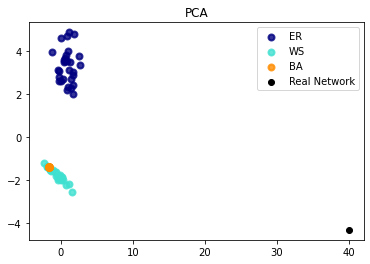

In [5]:
G = nx.read_edgelist("HVR_1.txt", nodetype = int,delimiter =',') #Malaria_genes, ER
print(classifica(G))

Feature: k1, Score: 0.00000
Feature: k2, Score: 0.45208
Feature: variance, Score: 0.03125
Feature: av_cl, Score: 0.00000
Feature: l, Score: 0.51667
Feature: r, Score: 0.00000
Feature: H, Score: 0.00000
Feature: Q, Score: 0.00000
ER


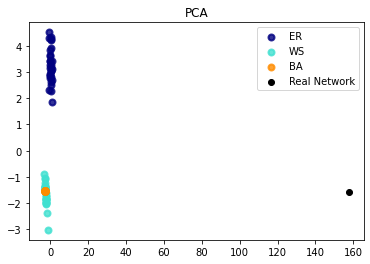

In [6]:
G = nx.read_edgelist("plant_pol_robertson.csv", nodetype = int,delimiter = ',') #plant_pol_robertson
print(classifica(G))

Feature: k1, Score: 0.00000
Feature: k2, Score: 0.00000
Feature: variance, Score: 0.00000
Feature: av_cl, Score: 0.00000
Feature: l, Score: 0.48333
Feature: r, Score: 0.00000
Feature: H, Score: 0.00000
Feature: Q, Score: 0.51667
BA


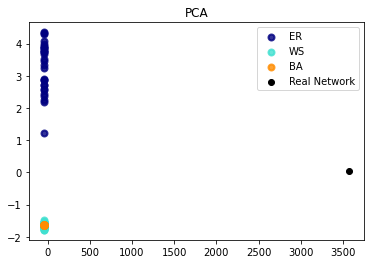

In [7]:
G = nx.read_edgelist("BNU1_0025864_1_DTI_DS01216.csv", nodetype = int,delimiter = ',',data=(('weight',float),)) #Human Brain
print(classifica(G))

Feature: k1, Score: 0.51667
Feature: k2, Score: 0.00000
Feature: variance, Score: 0.00000
Feature: av_cl, Score: 0.00000
Feature: l, Score: 0.00000
Feature: r, Score: 0.48333
Feature: H, Score: 0.00000
Feature: Q, Score: 0.00000
ER


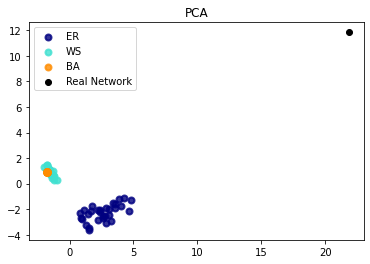

In [8]:
G = nx.read_edgelist("marvel_partnerships.csv", nodetype = int,delimiter = ',')
print(classifica(G))

Feature: k1, Score: 0.00000
Feature: k2, Score: 0.00000
Feature: variance, Score: 0.48333
Feature: av_cl, Score: 0.00000
Feature: l, Score: 0.00000
Feature: r, Score: 0.00000
Feature: H, Score: 0.51667
Feature: Q, Score: 0.00000
ER


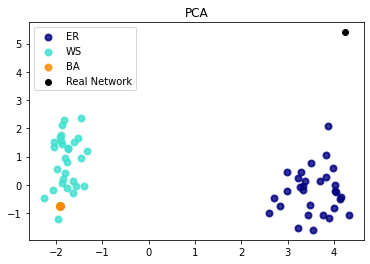

In [18]:
G = nx.read_edgelist("crime.csv", nodetype = int,delimiter = ',') #crime
print(classifica(G))

Feature: k1, Score: 0.00000
Feature: k2, Score: 0.00000
Feature: variance, Score: 0.00000
Feature: av_cl, Score: 1.00000
Feature: l, Score: 0.00000
Feature: r, Score: 0.00000
Feature: H, Score: 0.00000
Feature: Q, Score: 0.00000
WS


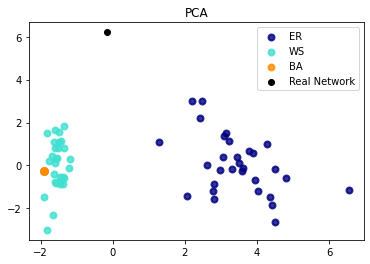

In [28]:
G = nx.read_edgelist("football.csv", nodetype = int,delimiter = ',') #Football
print(classifica(G))

Feature: k1, Score: 0.00000
Feature: k2, Score: 0.00000
Feature: variance, Score: 0.06061
Feature: av_cl, Score: 0.51667
Feature: l, Score: 0.00000
Feature: r, Score: 0.00000
Feature: H, Score: 0.00000
Feature: Q, Score: 0.42273
ER


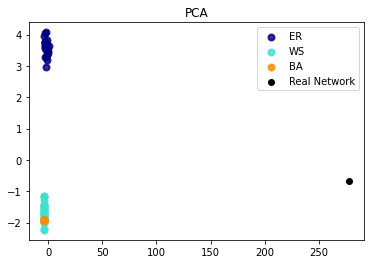

In [10]:
G = nx.read_edgelist("power.csv", nodetype = int,delimiter = ',') #Power
print(classifica(G))

Feature: k1, Score: 0.00000
Feature: k2, Score: 0.00000
Feature: variance, Score: 0.00000
Feature: av_cl, Score: 0.00000
Feature: l, Score: 0.51667
Feature: r, Score: 0.48333
Feature: H, Score: 0.00000
Feature: Q, Score: 0.00000
ER


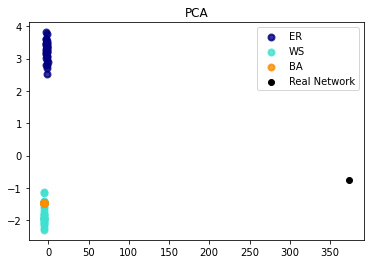

In [11]:
G = nx.read_edgelist("route_views.csv", nodetype = int,delimiter = ',') #Route, classificada com ER
print(classifica(G))

Feature: k1, Score: 0.00000
Feature: k2, Score: 0.51667
Feature: variance, Score: 0.00000
Feature: av_cl, Score: 0.00000
Feature: l, Score: 0.48333
Feature: r, Score: 0.00000
Feature: H, Score: 0.00000
Feature: Q, Score: 0.00000
ER


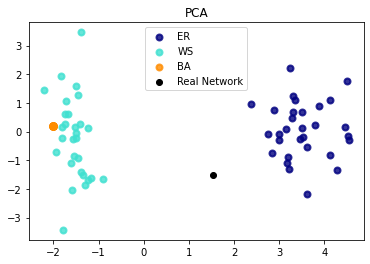

In [17]:
G = nx.read_edgelist("Cogentco.csv", nodetype = int,delimiter = ',') #Cogentco
print(classifica(G))